In [4]:
import celmech as cm
import rebound as rb
import numpy as np
from celmech.poisson_series import PSTerm, PoissonSeries
from celmech.disturbing_function import df_coefficient_C,evaluate_df_coefficient_dict
from test_particle_secular_hamiltonian import calc_g0_and_s0, SyntheticSecularTheory
from celmech.miscellaneous import frequency_modified_fourier_transform as fmft
from matplotlib import pyplot as plt

# Linear theory test particle exapmle
This example computes the secular evolution of a series of test particles using linear secular theory and compares the predictions against a numerical integration.

### N-body simulation

First, we set up and run a numerical simulation of two massive planets and lots of test particles

In [5]:
sim = rb.Simulation()
mtp = 0
sim.add(m = 1)
sim.add(m=1e-4,a=1,e=0.01)
sim.add(m=1e-4,a=2,e=0.02,pomega=np.pi*0.25,inc = 0.1,Omega = np.pi)
cm.nbody_simulation_utilities.align_simulation(sim)

# semi-major axes of test particles
sma_list = np.linspace(4,6,10)

sim.N_active = sim.N
for a in sma_list:
    sim.add(m=mtp,a = a,e=0.005,inc=0.01,pomega='uniform',Omega='uniform')
sim.integrator = 'whfast'
sim.ri_whfast.safe_mode = 0
sim.dt = np.min([p.P for p in sim.particles[1:]]) / 25.

Tfin_approx =5e6
total_steps = np.ceil(Tfin_approx / sim.dt)
Tfin = total_steps * sim.dt + sim.dt
Nout = 512
try: 
    results = cm.nbody_simulation_utilities.get_simarchive_integration_results("forced_tps_integrate.sa",coordinates='heliocentric')
except:
    sim.save_to_file("forced_tps_integrate.sa",step=int(np.floor(total_steps/Nout)),delete_file=True)
    sim.integrate(Tfin,exact_finish_time=0)
    results = cm.nbody_simulation_utilities.get_simarchive_integration_results("forced_tps_integrate.sa",coordinates='heliocentric')

/Users/hadden/miniconda3/envs/celmech/lib/python3.13/site-packages/rebound/simulationarchive.py:152: RuntimeWarning: The simulation might not be synchronized. You can manually synchronize it by calling sim.integrator_synchronize().
  warnings.warn("The simulation might not be synchronized. You can manually synchronize it by calling sim.integrator_synchronize().", RuntimeWarning)


### Construct synthetic secular theory
Now we'll use our integration results to develop a simple sythetic secular theory for the mass planets' secular eccentricity and inclination evolution

In [6]:

results['X'] = np.sqrt(2*(1-np.sqrt(1-results['e']**2))) * np.exp(1j * results['pomega'])
results['Y'] = (1-results['e']**2)**(0.25) * np.sin(0.5 * results['inc'] )* np.exp(1j * results['Omega'])

In [7]:
from celmech.miscellaneous import frequency_modified_fourier_transform as fmft

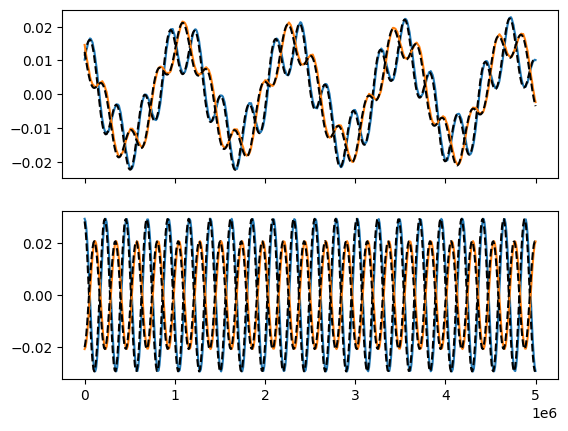

In [8]:
fig,ax = plt.subplots(2,1,sharex=True)
Xsolns = []
Ysolns = []
for i in range(2):
    freq_amp_dict = fmft(results['time'],results['X'][i],2)
    Xsolns.append(freq_amp_dict)
    ax[0].plot(results['time'],np.real(results['X'][i]))
    zsoln = np.sum([amp * np.exp(1j*freq*results['time']) for freq,amp in freq_amp_dict.items()],axis=0)
    ax[0].plot(results['time'],np.real(zsoln),'k--')

    freq_amp_dict = fmft(results['time'],results['Y'][i],1)
    Ysolns.append(freq_amp_dict)
    ax[1].plot(results['time'],np.real(results['Y'][i]))
    zsoln = np.sum([amp * np.exp(1j*freq*results['time']) for freq,amp in freq_amp_dict.items()],axis=0)
    ax[1].plot(results['time'],np.real(zsoln),'k--')

In [9]:
omega = list(Xsolns[0].keys())+list(Ysolns[0].keys())

xdict1 = dict(zip([tuple(row) for row in np.eye(3,dtype=int)],  list(Xsolns[0].values())))
xdict2 = dict(zip([tuple(row) for row in np.eye(3,dtype=int)],  list(Xsolns[1].values())))
ydict1 = dict(zip([(0,0,1),],  list(Ysolns[0].values())))
ydict2 = dict(zip([(0,0,1),],  list(Ysolns[1].values())))


ss_theory = SyntheticSecularTheory(
    [p.m for p in sim.particles[1:3]],
    [p.a for p in sim.particles[1:3]],omega,[xdict1,xdict2],[ydict1,ydict2]
)

### Compare predicted and simulated secular dynamics of test particles
Now we can generate predicted secular eovlution and plot against simulation results

In [10]:
from test_particle_secular_hamiltonian import TestParticleSecularHamiltonian

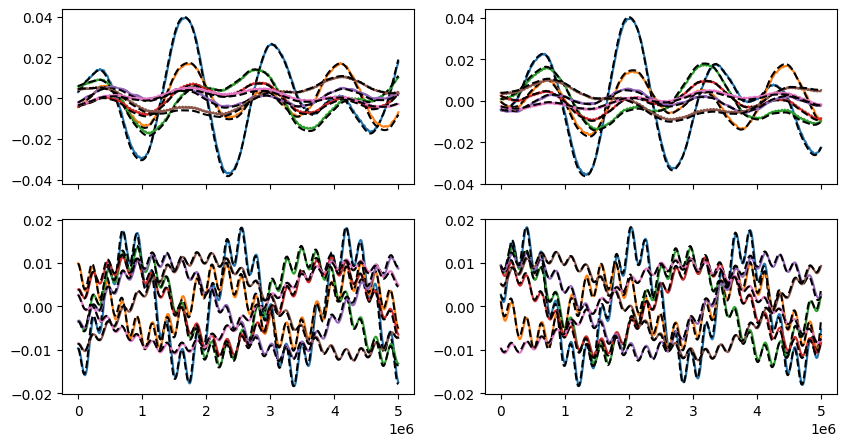

In [11]:
fig,ax = plt.subplots(2,2,sharex=True,figsize=(10,5))
times = results['time']
for ii in range(3,10):
    a0 = results['a'][ii][0]
    tp_h = TestParticleSecularHamiltonian(a0,ss_theory)
    x_numerical = results['X'][ii]
    y_numerical = 2*results['Y'][ii]
    
    x_analytic,y_analytic = tp_h.linear_theory_solution(x_numerical[0],y_numerical[0],times)
    
    ax[0,0].plot(results['time'],np.real(x_numerical))
    ax[0,0].plot(results['time'],np.real(x_analytic),'k--')
    ax[0,1].plot(results['time'],np.imag(x_numerical))
    ax[0,1].plot(results['time'],np.imag(x_analytic),'k--')

    
    ax[1,0].plot(results['time'],np.real(y_numerical))
    ax[1,0].plot(results['time'],np.real(y_analytic),'k--')
    ax[1,1].plot(results['time'],np.imag(y_numerical))
    ax[1,1].plot(results['time'],np.imag(y_analytic),'k--')


In [12]:
import pickle

In [13]:
with open("example_test_particle_secular_hamiltonian.bin","wb") as fi:
    pickle.dump(tp_h,fi)